In [12]:
import sys
import tqdm
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import gpytorch
import matplotlib.pyplot as plt

sys.path.append("../")
from estimator import ssge

In [33]:
class SSGE:
    def __init__(self, kernel: gpytorch.kernels.Kernel, eig_prop_threshold = 0.99, noise = 1e-8):
        self.kernel = kernel
        self.noise = noise
        self.eig_prop_threshold = eig_prop_threshold
        
        self.sample = None
        self.gram = None
        
        self.m = 0
        self.K = None
        self.eigval = None
        self.eigvec = None
        
    def fit(self, sample: torch.Tensor) -> None:
        assert sample.requires_grad
        
        if self.sample is not None:
            self.sample = torch.cat([self.sample, sample], axis = 0)
        else:
            self.sample = sample

        self.m = self.sample.shape[0]
        self.dim = self.sample.shape[1]
        self.K = self.kernel(self.sample).evaluate()
        if self.noise:
            self.K = self.K + self.noise * torch.eye(self.m, device = self.sample.device)
        
        self.eigval, self.eigvec = torch.linalg.eigh(self.K)
        #Tried to use torch.lobpcg as alternative to torch.linalg.eigh
        #but it seem is not stable yet.
        #self.eigval, self.eigvec = torch.lobpcg(self.K, min(self.m // 3, self.dim))
        with torch.no_grad():
            eig_props = self.eigval.cumsum(-1) / self.eigval.sum(-1, keepdims = True)
            eig_props *= eig_props < self.eig_prop_threshold
            self.j = torch.argmax(eig_props, -1)
        self.eigval = self.eigval[:self.j]
        self.eigvec = self.eigvec[:, :self.j]
        assert (self.eigval > 0).all(), "Kernel matrix is not postive definite."
        
        input_tensor = self.sample.unsqueeze(-1).repeat(1, 1, self.j)
        eigfun_hat = math.sqrt(self.m) * torch.einsum(
            "jnm,mk,k->j",
            self.kernel(torch.einsum("ndj->jnd", input_tensor), self.sample).evaluate(),
            self.eigvec,
            self.eigval.reciprocal()
        )
        #beta should have size d x j
        self.beta = - torch.autograd.grad(
            outputs = eigfun_hat,
            grad_outputs = torch.ones(eigfun_hat.shape, device = eigfun_hat.device),
            inputs = input_tensor,
            retain_graph = True,
        )[0].mean(0)
        
    def grad(self, x: torch.Tensor) -> torch.Tensor:
        
        assert x.requires_grad
        
        K_wing = self.kernel(x, self.sample).evaluate()
        eigfun_hat = math.sqrt(self.m) * torch.einsum("nm,mj->nj", K_wing, self.eigvec) / self.eigval
        gradfun_hat = torch.einsum("nj,mj->nm", eigfun_hat, self.beta)
        return torch.autograd.grad(
            outputs = gradfun_hat,
            grad_outputs = torch.ones(gradfun_hat.shape, device = gradfun_hat.device),
            inputs = x,
        )[0]

In [34]:
kernel = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.MaternKernel(
        ard_num_dims = 10
    )
)

In [35]:
estimator = SSGE(
    gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.MaternKernel(
            ard_num_dims = 10
        )
    )
)

In [36]:
dist = torch.distributions.multivariate_normal.MultivariateNormal(
    torch.zeros(10),
    torch.eye(10),
)

In [37]:
sample = dist.sample([100])
sample.requires_grad_(True)
estimator.fit(sample)

In [38]:
test_sample = dist.sample([100])
test_sample.requires_grad_(True)
estimator.grad(test_sample).shape

torch.Size([100, 10])

<h4>Error shrinks as the test sample size increases. </h4>

In [48]:
res = []
for num_sample in tqdm.tqdm(range(1, 500)):
    test_sample = dist.sample([num_sample * 10])
    test_sample.requires_grad_(True)
    grad_hat = estimator.grad(test_sample)
    dist.log_prob(test_sample).sum().backward()
    res.append(torch.dist(grad_hat, test_sample.grad) / num_sample)

100%|████████████████████████████████████████████████████████████████████| 499/499 [00:06<00:00, 78.20it/s]


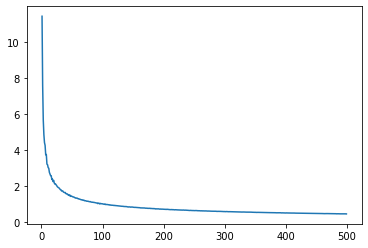

In [49]:
plt.plot(range(1,500), res)

In [24]:
test_sample = dist.sample([10])
test_sample.requires_grad_(True)
dist.log_prob(test_sample).sum().backward()
test_sample.grad.mean(0)

tensor([-0.0568,  0.2691,  0.0079,  0.0071,  0.3260, -0.4089,  0.1852, -0.1786,
         0.0917,  0.2401])